<a href="https://colab.research.google.com/github/hindanjali/Assignment2_part_a/blob/main/part_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image 
from tensorflow.keras.models import Sequential

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/nature_12K.zip

In [4]:
train_dir="/content/inaturalist_12K/train"

In [5]:
import pathlib
train_dir = pathlib.Path(train_dir)

In [6]:
test_dir="/content/inaturalist_12K/val"

In [7]:
import pathlib
test_dir = pathlib.Path(test_dir)

In [8]:
train_nature_images_dict = {
    'Amphibia': list(train_dir.glob('Amphibia/*')),
    'Animalia': list(train_dir.glob('Animalia/*')),
    'Arachnida': list(train_dir.glob('Arachnida/*')),
    'Aves': list(train_dir.glob('Aves/*')),
    'Fungi': list(train_dir.glob('Fungi/*')),
    'Insecta': list(train_dir.glob('Insecta/*')),
    'Mammalia': list(train_dir.glob('Mammalia/*')),
    'Mollusca': list(train_dir.glob('Mollusca/*')),
    'Plantae': list(train_dir.glob('Plantae/*')),
    'Reptilia': list(train_dir.glob('Reptilia/*')),


}

In [9]:
nature_labels_dict = {
    'Amphibia': 0,
    'Animalia': 1,
    'Arachnida': 2,
    'Aves': 3,
    'Fungi': 4,
    'Insecta': 5,
    'Mammalia': 6,
    'Mollusca': 7,
    'Plantae': 8,
    'Reptilia': 9,

}

In [10]:
x_train, y_train= [], []
for nature, images in train_nature_images_dict.items():
    for image in images:
       # print(image)
        img = cv2.imread(str(image))
        try:
          resized_img = cv2.resize(img,(120,120))#, cv2.INTER_AREA)
        except cv2.error:
          continue
        x_train.append(resized_img)
        y_train.append(nature_labels_dict[nature])
        

In [11]:
test_nature_images_dict = {
    'Amphibia': list(test_dir.glob('Amphibia/*')),
    'Animalia': list(test_dir.glob('Animalia/*')),
    'Arachnida': list(test_dir.glob('Arachnida/*')),
    'Aves': list(test_dir.glob('Aves/*')),
    'Fungi': list(test_dir.glob('Fungi/*')),
    'Insecta': list(test_dir.glob('Insecta/*')),
    'Mammalia': list(test_dir.glob('Mammalia/*')),
    'Mollusca': list(test_dir.glob('Mollusca/*')),
    'Plantae': list(test_dir.glob('Plantae/*')),
    'Reptilia': list(test_dir.glob('Reptilia/*')),

}


In [12]:
x_test, y_test= [], []

for nature, images in test_nature_images_dict.items():
    for image in images:
        #print(image)
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(120,120))
        x_test.append(resized_img)
        y_test.append(nature_labels_dict[nature])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.10)# random_state=0)
#print(len(x_train), len(x_val),len( y_train),len( y_val))

In [14]:
x_train = np.array(x_train)/255
y_train = np.array(y_train)

In [15]:
x_val = np.array(x_val)/255
y_val = np.array(y_val)

In [16]:
x_test = np.array(x_test)/255
y_test = np.array(y_test)

In [17]:
#x_train = x_train/255
#x_test = x_test/255a
#x_val = x_val/255

In [18]:
IMAGE_SIZE = [120, 120]

In [19]:
num_classes=10

In [ ]:
!pip install wandb

In [25]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: hindanjali (use `wandb login --relogin` to force relogin)


True

In [24]:
sweep_config={
    'method':'random',
    'metrix' :
    {'name':'accuracy',
    'goal' : 'maximize'
  },
  'parameters':{
   'n_filter':{'values':[16,32,64]},
   'dropout':{'values':[0.2,0.3]},
   'data_aug':{'values':['yes','no']},
   'batch_norm':{'values':['yes','no']},
   'learning_rate':{'values':[0.0001,0.001] },
   'epochs':{'values':[5]},
   'activation_f':{'values':['tanh','relu']},
   'n_neurons':{'values':[32,64,128]},
   's_filter':{'values':[3,5,10]},
   'weight_decay':{'values':[0.0005,0.5]}
  }
}


InceptionV3

In [25]:
def inc3():
  inc = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
  for layer in inc.layers:
    layer.trainable = False
  x = Flatten()(inc.output)
  prediction = Dense(num_classes, activation='relu')(x)
  model = Model(inputs=inc.input, outputs=prediction)
  model.summary()

  #model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
  model.fit(x_train, y_train, epochs=5,validation_data=(x_val,y_val),callbacks=[WandbCallback()])

In [26]:
def a1():
  config_defaults={
  'epochs':5,
  'activation_f':'relu'
  }

  run=wandb.init(config=config_defaults)

  config=wandb.config

  inc3()
  #model.summary()model.summary()
  #model.summary()
  #print(model.summary())
  #model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

 # model.fit(x_train, y_train, epochs=config.epochs,validation_data=(x_val,y_val),callbacks=[WandbCallback()])



In [27]:
sweep_id = wandb.sweep(sweep_config,project="Assign2_part_b")

Create sweep with ID: piu689re
Sweep URL: https://wandb.ai/hindanjali/Assign2_part_b/sweeps/piu689re


In [ ]:
wandb.agent(sweep_id,a1)

InceptionResNetV2

In [1]:
def iresnet():
  incresnet = InceptionResNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
  for layer in incresnet.layers:
    layer.trainable = False
  x = Flatten()(incresnet.output)
  prediction = Dense(num_classes, activation='relu')(x)
  model = Model(inputs=incresnet.input, outputs=prediction)
  #model.summary()

  #model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
  model.fit(x_train, y_train, epochs=5,validation_data=(x_val,y_val),callbacks=[WandbCallback()])

In [2]:
def a2():
  config_defaults={
  'epochs':5,
  'activation_f':'relu'
  }

  run=wandb.init(config=config_defaults)

  config=wandb.config

  iresnet()
  #model.summary()model.summary()
  #model.summary()
  #print(model.summary())
  #model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

 # model.fit(x_train, y_train, epochs=config.epochs,validation_data=(x_val,y_val),callbacks=[WandbCallback()])



In [ ]:
wandb.agent(sweep_id,a2)

ResNet50

In [ ]:
run=wandb.init()

In [34]:
def resnet():
  res =  ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
  for layer in res.layers:
    layer.trainable = False
  x = Flatten()(res.output)
  prediction = Dense(num_classes, activation='relu')(x)
  model = Model(inputs=res.input, outputs=prediction)
  #model.summary()

  #model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
  model.fit(x_train, y_train, epochs=1,validation_data=(x_val,y_val),callbacks=[WandbCallback()])

In [ ]:
resnet()

In [2]:
def a3():
  config_defaults={
  'epochs':5,
  'activation_f':'relu'
  }

  run=wandb.init(config=config_defaults)

  config=wandb.config

  resnet()
  #model.summary()model.summary()
  #model.summary()
  #print(model.summary())
  #model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

 # model.fit(x_train, y_train, epochs=config.epochs,validation_data=(x_val,y_val),callbacks=[WandbCallback()])



In [ ]:
wandb.agent(sweep_id,a3)

Xception

In [ ]:
run=wandb.init()

In [26]:
def xcep():
  xc =  ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
  for layer in xc.layers:
    layer.trainable = False
  x = Flatten()(xc.output)
  prediction = Dense(num_classes, activation='relu')(x)
  model = Model(inputs=xc.input, outputs=prediction)
  #model.summary()

  #model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
  model.fit(x_train, y_train, epochs=5,validation_data=(x_val,y_val),callbacks=[WandbCallback()])

In [ ]:
xcep()

In [ ]:
def a4():
  config_defaults={
  'epochs':5,
  'activation_f':'relu'
  }

  run=wandb.init(config=config_defaults)

  config=wandb.config

  xcep()
  #model.summary()model.summary()
  #model.summary()
  #print(model.summary())
  #model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

 # model.fit(x_train, y_train, epochs=config.epochs,validation_data=(x_val,y_val),callbacks=[WandbCallback()])



In [ ]:
wandb.agent(sweep_id,a4)

In [5]:
model=['InceptionV3','ResNet50','InceptionResNetV2','Xception']
av_cpu=[98.59,44.133,44.15,30.717]
av_mem=[52.5,44,44.15,53.9]


In [22]:
n = np.arange(len(model))

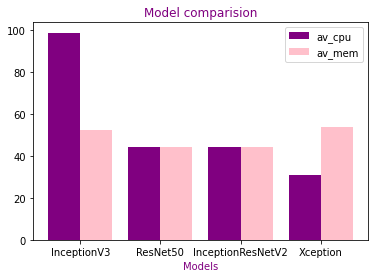

In [40]:
plt.bar(n-0.2,av_cpu, width=0.4, label="av_cpu",color='purple')
plt.bar(n+0.2,av_mem, width=0.4,label="av_mem",color='pink')

plt.xticks(xpos,model)
plt.xlabel("Models",color='purple')
plt.title('Model comparision',color='purple')
plt.legend()